## Data Preprocessing
this notebook will parse the .mat file into more friendly numpy style data and save as pickle file <br \>
**NOTE: **DO NOT cross run this notebook! (because a same data name is used)

In [82]:
from __future__ import print_function
from scipy import io as sio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from six.moves import cPickle as pickle
%matplotlib inline

*next cell define a function loads the data from .mat file*

In [83]:
def load_mat_data(filename = None):
    '''WARNING: this function will flatten y into shape(len,)'''
    print("loading data from ", filename)
    try:
        data_dict = sio.loadmat(filename)
    except:
        print("File Not Found!")
        return None
    X = data_dict['X']
    y = data_dict['y'].flatten().astype(float)
    print("SUCCESS!")
    print("shape of data:", X.shape, "shape of labels:", y.shape)
    return X, y


print("\nLOADING MAT DATA...")

train_X, train_y = load_mat_data("train_32x32.mat")
test_X, test_y = load_mat_data("test_32x32.mat")
extra_X,extra_y = load_mat_data("extra_32x32.mat")


'''fake data set just for fast testing
    comment the original and uncomment the three lines below'''
#train_X, train_y = 255.* np.random.random([32,32,3,300]), .1*np.random.randint(1,11, [300,])
#test_X, test_y = 255.* np.random.random([32,32,3,50]), .1*np.random.randint(1,11, [50,])
#extra_X, extra_y = 255.* np.random.random([32,32,3,600]), .1*np.random.randint(1,11, [600,])


LOADING MAT DATA...
loading data from  train_32x32.mat
SUCCESS!
shape of data: (32, 32, 3, 73257) shape of labels: (73257,)
loading data from  test_32x32.mat
SUCCESS!
shape of data: (32, 32, 3, 26032) shape of labels: (26032,)
loading data from  extra_32x32.mat
SUCCESS!
shape of data: (32, 32, 3, 531131) shape of labels: (531131,)


'fake data set just for fast testing\n    comment the original and uncomment the three lines below'

In [84]:
# the data store the 0 as 10, make it python friendly
num_labels = 10
train_y[train_y == 10.0] = 0
test_y[test_y == 10.0] = 0
extra_y[extra_y == 10.0] = 0

In [110]:
# peek the distribution of the data
def peek_distribution(y, title = None, num_labels = 10):
    y_stat = [len(np.where(y == float(i))[0]) for i in range(num_labels)]
    ind = np.arange(10)
    width = .7
    plt.bar(ind, y_stat, width = width)
    plt.ylabel('Number')
    plt.xlabel('label')
    plt.title(title)
    plt.xticks(ind + .5*width, ind)
    plt.show

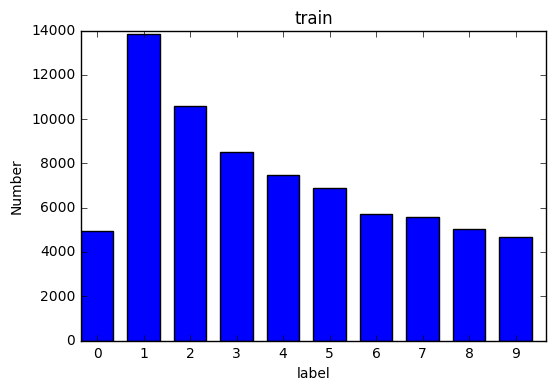

In [94]:
peek_distribution(train_y, "train")

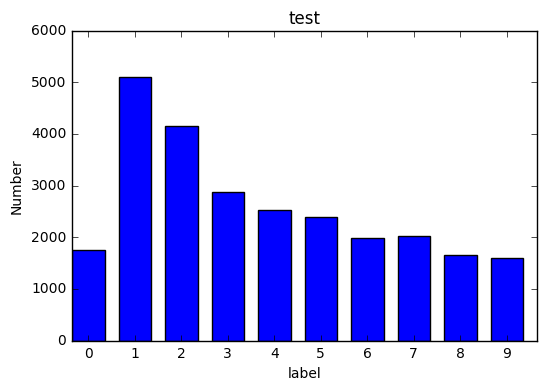

In [95]:
peek_distribution(test_y, "test")

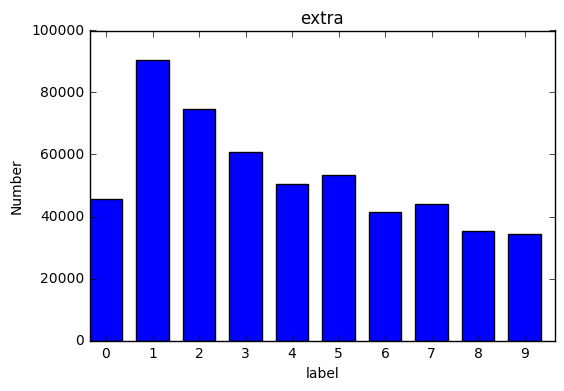

In [96]:
peek_distribution(extra_y, "extra")

*next cell will reformat the data*

In [97]:
def reformat(X):
    ## reformat X
    new_X = X.transpose((3,0,1,2))
    print("X's shape after reformating: ", new_X.shape) 
    return new_X
    
print("reformating training data")    
train_X = reformat(train_X)
print("reformating testing data")
test_X = reformat(test_X)
print("reformating extra data")
extra_X = reformat(extra_X)

reformating training data
X's shape after reformating:  (73257, 32, 32, 3)
reformating testing data
X's shape after reformating:  (26032, 32, 32, 3)
reformating extra data
X's shape after reformating:  (531131, 32, 32, 3)


*next cell will transfer the images to grayscale*

In [98]:
# mean gray
train_X = np.mean(train_X, axis = 3)
test_X = np.mean(test_X, axis = 3)
extra_X = np.mean(extra_X, axis = 3)
print(train_X.shape)
print(test_X.shape)
print(extra_X.shape)

(73257, 32, 32)
(26032, 32, 32)
(531131, 32, 32)


*next cell will check if the images are good*

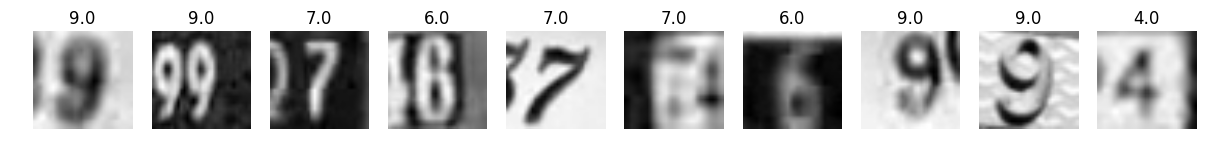

In [123]:

def sample_display(random_idc = None):
    plt.rcParams["figure.figsize"] = (15.0, 15.0)
    f, ax = plt.subplots(nrows = 1, ncols = 10)
    if random_idc is None:
        random_idc = np.random.randint(0, train_X.shape[0], 10)
    for i, j in enumerate(random_idc):
        ax[i].axis('off')
        ax[i].set_title(train_y[j], loc = 'center')
        ax[i].imshow(train_X[j], cmap = 'gray')
        
        
random_idc = np.random.randint(0, train_X.shape[0], 10)
sample_display(random_idc)

In [100]:
print(random_idc)

[22971 62749 31829 45317 39867 29373 16420 22486 54508 48668]


*next cell will do GCN to the images*

In [101]:
imsize = 32
def gcn(X):
    means = np.mean(X, axis = (1, 2))
    stds = np.std(X, axis = (1, 2), ddof = 1)
    stds[stds < 1e-8] = 1.
    new_X = X - np.tensordot(means, np.ones([imsize, imsize]), 0)
    new_X = new_X/np.tensordot(stds, np.ones([imsize, imsize]), 0)
    return new_X

print("dealing with training data...")
%time train_X = gcn(train_X)
print("dealing with testing data...")
%time test_X = gcn(test_X)
print("dealing with extra data...")
%time extra_X = gcn(extra_X)
print(train_X.shape)
print(test_X.shape)
print(extra_X.shape)

dealing with training data...
CPU times: user 1.83 s, sys: 564 ms, total: 2.39 s
Wall time: 6.72 s
dealing with testing data...
CPU times: user 772 ms, sys: 124 ms, total: 896 ms
Wall time: 2.52 s
dealing with extra data...
CPU times: user 16.3 s, sys: 1min 5s, total: 1min 21s
Wall time: 21min 34s
(73257, 32, 32)
(26032, 32, 32)
(531131, 32, 32)


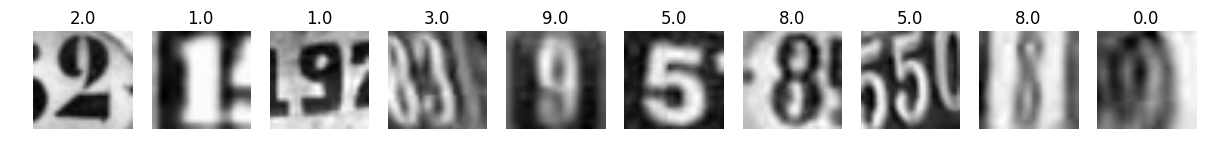

In [102]:
sample_display(random_idc)

*next cell will split the data into random shuffle train, valid, and test data for pickling* <BR \>
**WARNING:** Now you **SHOULD NOT** use the fake data

In [103]:
# a scheme for pickling data
# training: 100,000 = all original training excluding those for valid, plus samples from extra
# validation: 6,000 = 400 for each class in original training, plus 200 for each in extra 
# testing: stay the same

# make some random indices

num_labels = 10

def random_idc(y, each, num_labels = 10):
    '''
    generate random entries of size 'each' for a data set
    of normal distribution (1/num_labels)
    '''
    idc = []
    for i in range(num_labels):
        cand = np.where(y == i)[0]
        idc.extend(cand[:each/2])
        idc.extend(cand[-each/2:])
    idc = np.array(idc)
    np.random.seed()
    np.random.shuffle(idc)
    return idc

val_idc = random_idc(train_y, 400)
val_idc_e = random_idc(extra_y, 200)

print("picking validation data from training data and extra data...")
val_X = np.concatenate([train_X[val_idc], extra_X[val_idc_e]], axis = 0)
val_y = np.concatenate([train_y[val_idc], extra_y[val_idc_e]], axis = 0)

# exclude validation data from both training and extra
train_X = np.delete(train_X, val_idc, 0)
train_y = np.delete(train_y, val_idc, 0)
extra_X = np.delete(extra_X, val_idc_e, 0)
extra_y = np.delete(extra_y, val_idc_e, 0)

print("SUCCESS!")
print(train_X.shape)
print(extra_X.shape)
print(val_X.shape)

picking validation data from training data and extra data...
SUCCESS!
(69257, 32, 32)
(529131, 32, 32)
(6000, 32, 32)


In [105]:
# since the data is of bad distribution, it should be rearrange
train_each = 10000
stat_min = min(y_stat)
num_more = train_each - stat_min

train_idc = random_idc(train_y, stat_min)
train_idc_e = random_idc(extra_y, num_more)

**NOTE:** implementing next cell will delete the data in train_X and extra_y that is not needed

In [106]:
print("building a normal distribution training dataset")
train_X = np.concatenate([train_X[train_idc], extra_X[train_idc_e]], axis = 0)
train_y = np.concatenate([train_y[train_idc], extra_y[train_idc_e]], axis = 0)

print("SUCCESS!")
print(train_X.shape)
print(val_X.shape)

building a normal distribution training dataset
SUCCESS!
(100000, 32, 32)
(6000, 32, 32)


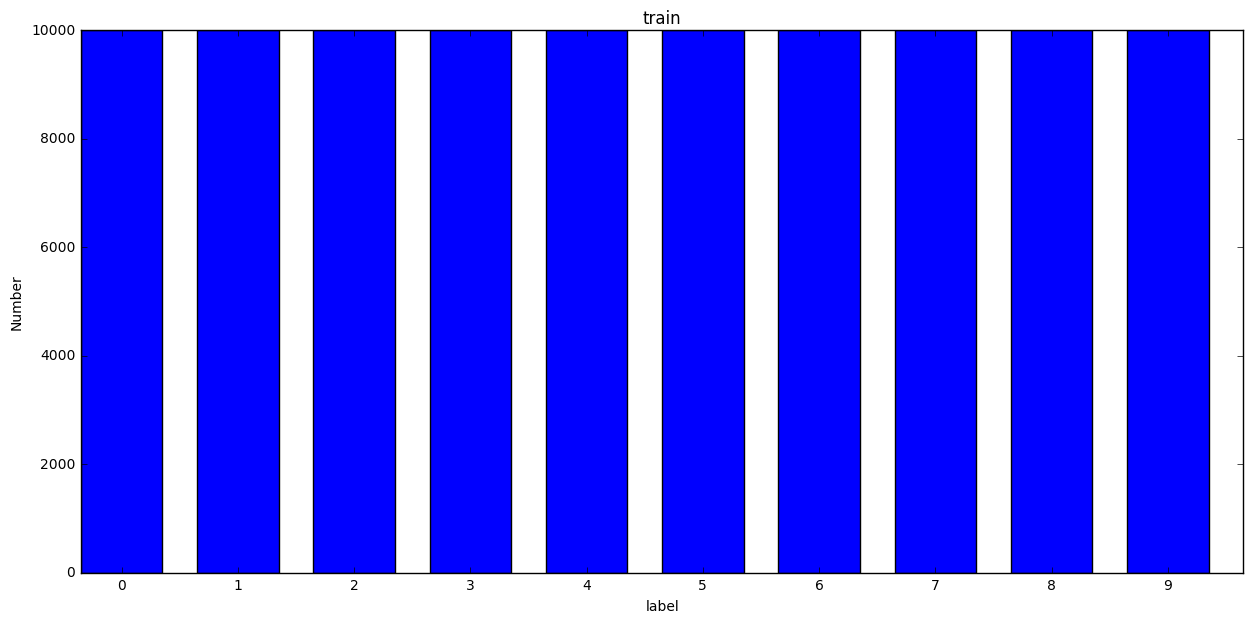

In [136]:
plt.rcParams['figure.figsize'] = (15.0,7.0)
peek_distribution(train_y, 'train')

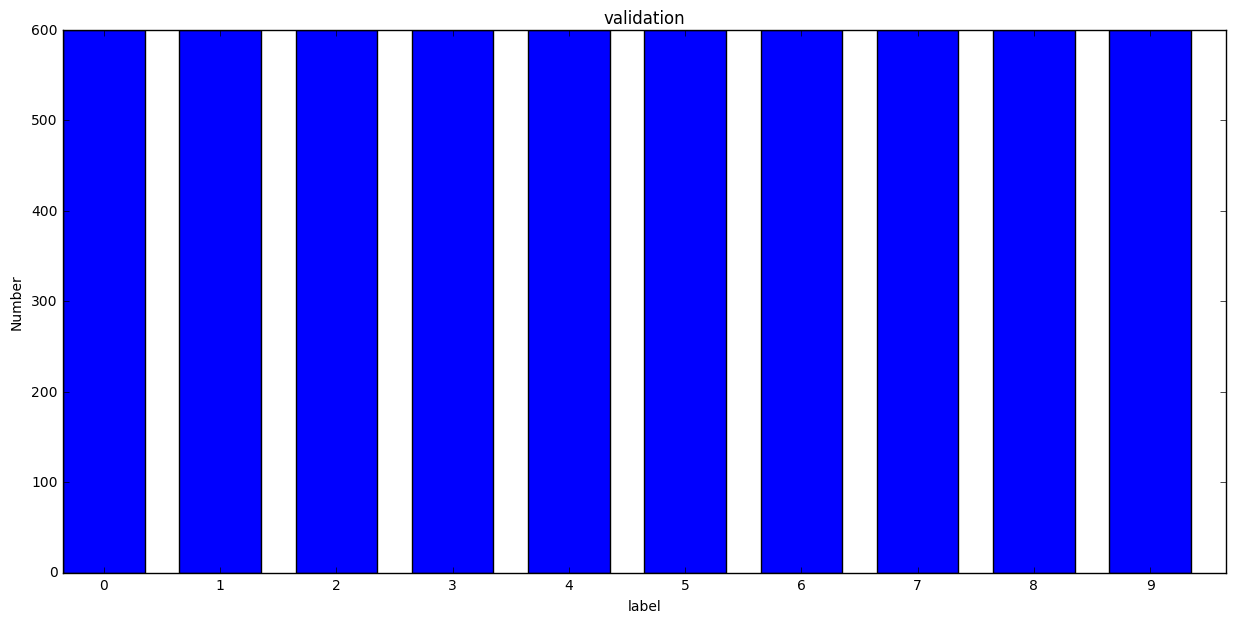

In [137]:
peek_distribution(val_y, 'validation')

*the next cell will pickle the file*

In [141]:
import os
def maybe_pickle(file_name, X, y, force = False):
    if os.path.exists(file_name) and not force:
        print("%s already presents, you can set 'force = True' to overwrite" %file_name)
    else:
        print("pickling %s" %file_name)
        data = {"X": X, "y": y}
        try:
            with open(file_name, 'wb') as f:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print("sorry, pickling failed: ", e)
        
%time maybe_pickle("train.pickle", train_X, train_y)
%time maybe_pickle("validation.pickle", val_X, val_y)
%time maybe_pickle("test.pickle", test_X, test_y)
        
    
        

train.pickle already presents, you can set 'force = True' to overwrite
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 560 µs
validation.pickle already presents, you can set 'force = True' to overwrite
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 202 µs
test.pickle already presents, you can set 'force = True' to overwrite
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 324 µs
